In [1]:
%pwd

'/Users/mengmeng/bootcamp_Shuchen_Meng/homework/stage08_exploratory-data-analysis'

In [3]:
%mkdir -p {data/raw,data/processed,src,docs}
!touch {data/raw/.gitkeep,data/processed/.gitkeep,src/__init__.py,docs/README.md}

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import os
from datetime import date

TICKER = "SPY"          
START  = "2010-01-01"
END    = date.today().isoformat()
RAW_OUT = "data/raw/etf_{}_daily.csv".format(TICKER)  

df = yf.download(TICKER, start=START, end=END, interval="1d", progress=False, group_by="column")

if isinstance(df.columns, pd.MultiIndex):
    df.columns = ["_".join([c for c in col if c]) for col in df.columns.values]


df = df.rename_axis("Date").reset_index()

df = df.sort_values("Date").drop_duplicates(subset=["Date"])

os.makedirs("data/raw", exist_ok=True)
df.to_csv(RAW_OUT, index=False)
print("Saved:", RAW_OUT, "rows:", len(df))
df.head()

/var/folders/mm/zd5mx6qs3wz9922pdygh0dzc0000gn/T/ipykernel_14436/3129557102.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start=START, end=END, interval="1d", progress=False, group_by="column")


Saved: data/raw/etf_SPY_daily.csv rows: 3934


,Date,Close_SPY,High_SPY,Low_SPY,Open_SPY,Volume_SPY
0,2010-01-04,85.515633,85.560905,84.142312,84.791244,118944600
1,2010-01-05,85.742012,85.779743,85.153447,85.462824,111579900
2,2010-01-06,85.802383,86.013663,85.591104,85.659013,116074400
3,2010-01-07,86.164581,86.270221,85.402462,85.643925,131091100
4,2010-01-08,86.451332,86.489063,85.764674,85.938223,126402800


In [10]:
df["ret1"] = df["Close_SPY"].pct_change()
df["ret_fwd1"] = df["ret1"].shift(-1)
df.head()

,Date,Close_SPY,High_SPY,Low_SPY,Open_SPY,Volume_SPY,ret1,ret_fwd1
0,2010-01-04,85.515633,85.560905,84.142312,84.791244,118944600,NaN,0.002647
1,2010-01-05,85.742012,85.779743,85.153447,85.462824,111579900,0.002647,0.000704
2,2010-01-06,85.802383,86.013663,85.591104,85.659013,116074400,0.000704,0.004221
3,2010-01-07,86.164581,86.270221,85.402462,85.643925,131091100,0.004221,0.003328
4,2010-01-08,86.451332,86.489063,85.764674,85.938223,126402800,0.003328,0.001396


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
sns.set(style="whitegrid", context="talk")

In [12]:
print("=== .info() ===")
print(df.info())

print("\n=== .describe() (numeric only) ===")
print(df.describe().T)


print("\n=== Missing values per column ===")
print(df.isna().sum())

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
print("\nNumeric columns:", num_cols)
print("Categorical columns:", cat_cols)

=== .info() ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3934 entries, 0 to 3933
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        3934 non-null   datetime64[ns]
 1   Close_SPY   3934 non-null   float64       
 2   High_SPY    3934 non-null   float64       
 3   Low_SPY     3934 non-null   float64       
 4   Open_SPY    3934 non-null   float64       
 5   Volume_SPY  3934 non-null   int64         
 6   ret1        3933 non-null   float64       
 7   ret_fwd1    3933 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 246.0 KB
None

=== .describe() (numeric only) ===
             count                           mean                  min  \
Date          3934  2017-10-26 03:59:45.358414080  2010-01-04 00:00:00   
Close_SPY   3934.0                      261.16797             77.80323   
High_SPY    3934.0                     262.536154            78.

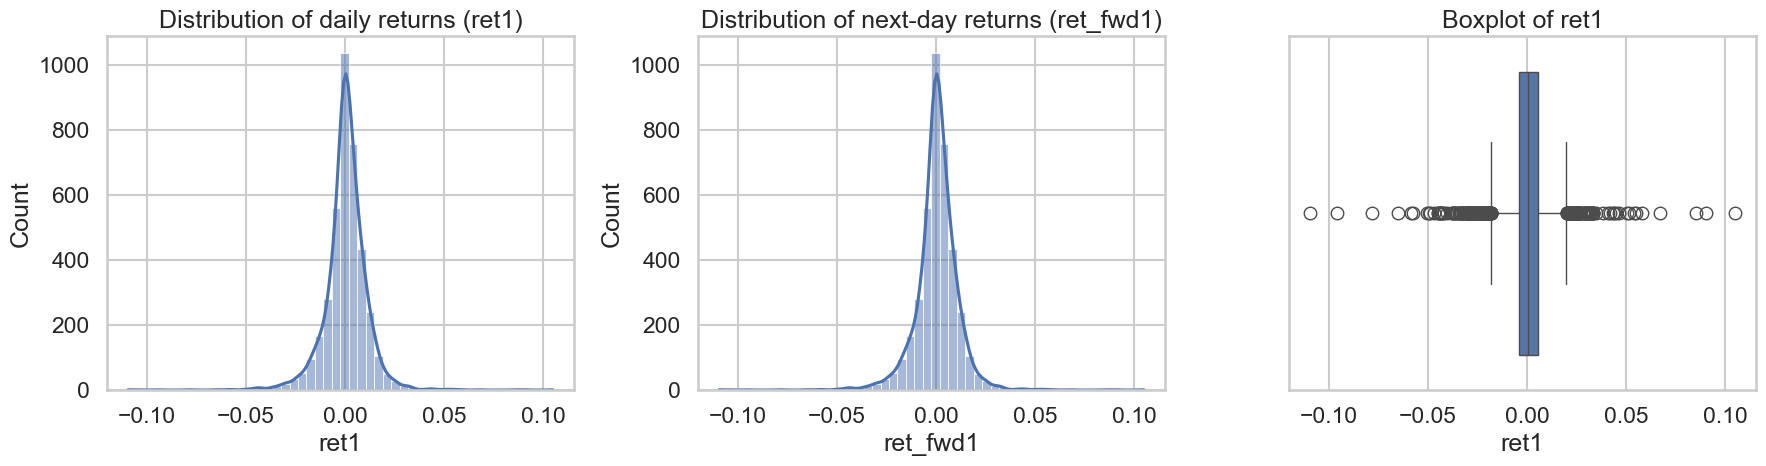

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))


sns.histplot(df["ret1"].dropna(), bins=50, ax=axes[0], kde=True)
axes[0].set_title("Distribution of daily returns (ret1)")


sns.histplot(df["ret_fwd1"].dropna(), bins=50, ax=axes[1], kde=True)
axes[1].set_title("Distribution of next-day returns (ret_fwd1)")


sns.boxplot(x=df["ret1"], ax=axes[2])
axes[2].set_title("Boxplot of ret1")

plt.tight_layout()
plt.show()

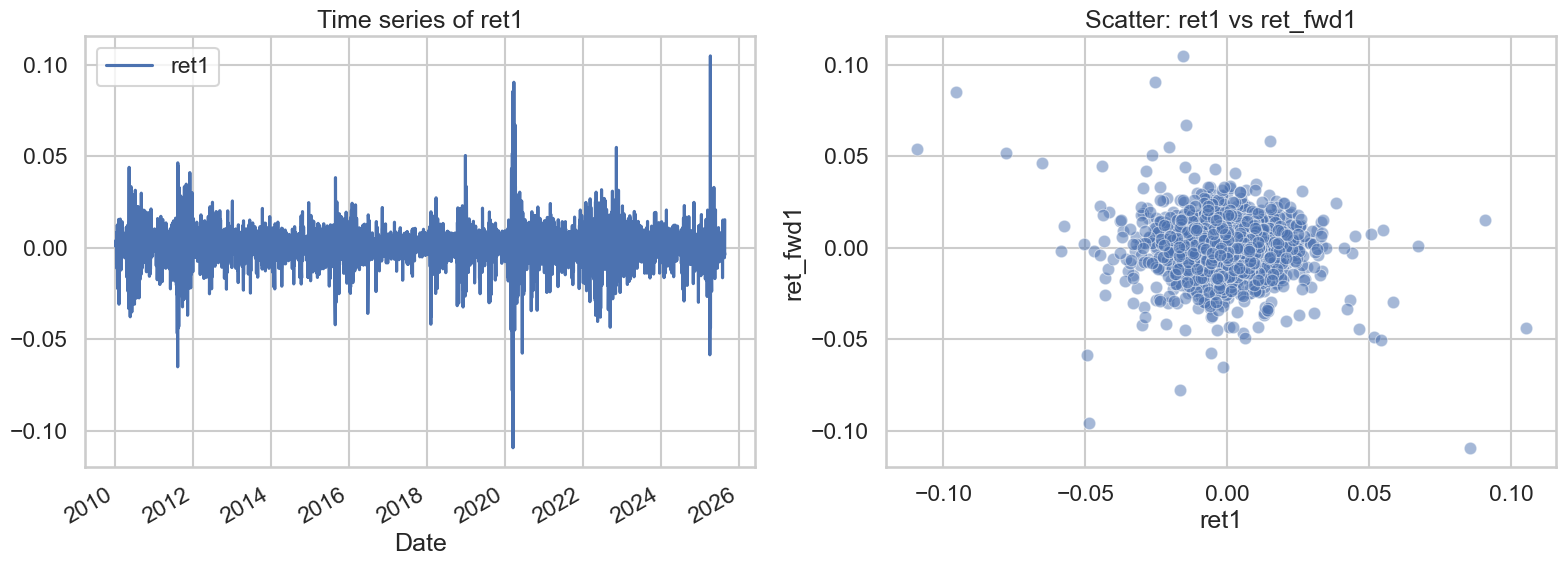

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))


df.set_index("Date")[["ret1"]].plot(ax=axes[0])
axes[0].set_title("Time series of ret1")

#ret1 vs ret_fwd1
sns.scatterplot(x="ret1", y="ret_fwd1", data=df, ax=axes[1], alpha=0.5)
axes[1].set_title("Scatter: ret1 vs ret_fwd1")

plt.tight_layout()
plt.show()

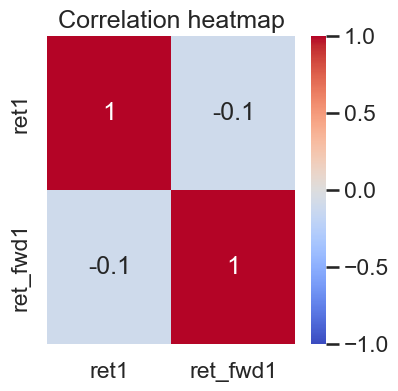

In [15]:
corr = df[["ret1","ret_fwd1"]].corr()
plt.figure(figsize=(4,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation heatmap")
plt.show()

- **Skewness / Distribution**:  
  - Both `ret1` and `ret_fwd1` are centered around 0, but with long tails (heavy-tailed).  
  - The boxplot shows clear outliers (large positive/negative daily returns).  
- **Outliers**:  
  - Likely correspond to market shocks (e.g., 2020 COVID crash).  
- **Seasonality/Structure**:  
  - No strong daily seasonality visible in returns.  
  - Time-series plot shows volatility clustering: periods of high volatility followed by calmer periods.  
- **Bivariate structure**:  
  - The scatter of `ret1` vs `ret_fwd1` looks cloud-like, suggesting weak linear predictability.  
  - Correlation heatmap confirms near-zero correlation between today’s and next-day returns.

In [17]:
def detect_outliers_iqr(series: pd.Series, k: float = 1.5) -> pd.Series:
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return (series < lower) | (series > upper)

# 2. Z-score based detection
def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
    mean = series.mean()
    std = series.std()
    if std == 0:
        return pd.Series([False]*len(series), index=series.index)  # 没有波动则无 outlier
    z_scores = (series - mean) / std
    return np.abs(z_scores) > threshold

In [20]:
#  ret1 
outliers_iqr = detect_outliers_iqr(df["ret1"].dropna())
outliers_z   = detect_outliers_zscore(df["ret1"].dropna(), threshold=3.0)

print("IQR outliers:", outliers_iqr.sum())
print("Z-score outliers:", outliers_z.sum())


comparison = pd.DataFrame({
    "ret1": df["ret1"].dropna(),
    "IQR": outliers_iqr,
    "Zscore": outliers_z
})
comparison["both"] = comparison["IQR"] & comparison["Zscore"]

print("\nOverlap counts:")
print(comparison[["IQR","Zscore","both"]].sum())

comparison['IQR'].value_counts()
comparison['Zscore'].value_counts()

IQR outliers: 264
Z-score outliers: 58

Overlap counts:
IQR       264
Zscore     58
both       58
dtype: int64


Zscore
False    3875
True       58
Name: count, dtype: int64

### Implications for Next Step
- **Feature Engineering**:  
  - Simple returns (`ret1`) are not strongly predictive of next-day returns (`ret_fwd1`).  
  - To capture structure, I may try rolling-window features (moving average, volatility, momentum).  
- **Outlier Handling**:  
  - The IQR method is more sensitive and tags many observations in the fat tails.  
  - The Z-score method is stricter and identifies only the most extreme moves.  
  - In financial data, fat tails are common; using IQR may over-flag while Z-score may under-flag.  
  - For risk analysis, we might keep both perspectives:  
      - Use IQR to study volatility clustering / broader tail behavior.  
      - Use Z-score to focus on true market shock days.
- **Data Cleaning**:  
  - Minimal missing values, but forward-looking features (`ret_fwd1`) naturally have one missing at the end.  
  - Ensure alignment when shifting series for modeling.  
- **Next Step**:  
  - Build a baseline regression: `ret_fwd1 ~ ret1`.  
  - Then experiment with richer features (MA gaps, volatility) to see if predictability improves.

In [21]:
!git add .
!git commit -m "stage08_exploratory-data-analysis"
!git push

[main 5357eab] stage08_exploratory-data-analysis
 6 files changed, 4596 insertions(+)
 create mode 100644 homework/stage08_exploratory-data-analysis/data/processed/.gitkeep
 create mode 100644 homework/stage08_exploratory-data-analysis/data/raw/.gitkeep
 create mode 100644 homework/stage08_exploratory-data-analysis/data/raw/etf_SPY_daily.csv
 create mode 100644 homework/stage08_exploratory-data-analysis/docs/README.md
 create mode 100644 homework/stage08_exploratory-data-analysis/src/__init__.py
 create mode 100644 homework/stage08_exploratory-data-analysis/stage08_exploratory-data-analysis.ipynb
Enumerating objects: 14, done.
Counting objects: 100% (14/14), done.
Delta compression using up to 10 threads
Compressing objects: 100% (8/8), done.
Writing objects: 100% (12/12), 331.40 KiB | 8.96 MiB/s, done.
Total 12 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To github.com:mengmeng12/bootcamp_Shuchen_Meng.git
   e667240